In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Classification using k-Nearest Neighbors

Let us first generate some synthetic data.

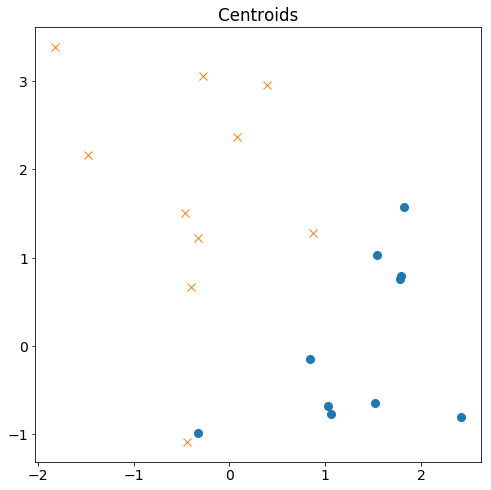

In [3]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

# Plot centroids
plt.plot(class0_centroids[:, 0], class0_centroids[:, 1], "o", markersize=8)
plt.plot(class1_centroids[:, 0], class1_centroids[:, 1], "x", markersize=8)
plt.title("Centroids")

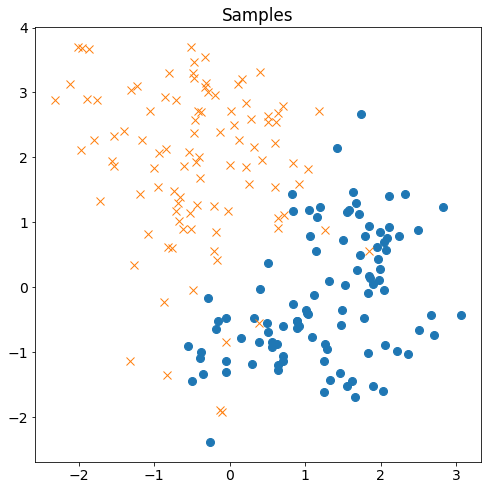

In [4]:
samples_per_class = 100

class0_labels = np.random.randint(10, size = samples_per_class)
class1_labels = np.random.randint(10, size = samples_per_class)

class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

plt.plot(class0_samples[:, 0], class0_samples[:, 1], "o", markersize=8)
plt.plot(class1_samples[:, 0], class1_samples[:, 1], "x", markersize=8)
plt.title("Samples")

Let us group these points in a nice way. For binary classification problems like this one, the way data is usually arranged is in

- a feature matrix $X$ of size $N \times P$, where $N$ is the number of samples and $P$ is the number of features (in our case $N = 200$ and $P = 2$);
- a label vector $y \in \{0, 1\}^N$ saying to which class each sample belongs to

In [5]:
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

print(X)
print(y)

n_samples, n_features = np.shape(X)

[[  2.49635219e+00   8.84473570e-01]
 [  2.10550493e+00   9.23601187e-01]
 [  1.11824916e+00  -1.17491971e-01]
 [  2.05508145e+00  -8.88665576e-01]
 [  7.04207746e-01  -6.03050699e-01]
 [  1.41560760e+00   2.14568214e+00]
 [  2.35472206e+00  -1.02472042e+00]
 [  3.05880865e+00  -4.22917174e-01]
 [  1.32879855e+00  -1.43358822e+00]
 [  4.96360925e-01  -5.47397815e-01]
 [  6.34132261e-01  -1.19551828e+00]
 [  1.68057709e+00   2.70432203e-01]
 [  1.55646575e+00  -1.51601066e+00]
 [  1.95241270e+00   6.22051721e-01]
 [  3.21458242e-01  -4.68209370e-01]
 [  8.85979145e-01  -6.29569390e-01]
 [  1.52570586e+00   3.58008969e-02]
 [  1.85248667e+00   1.41074113e-01]
 [ -3.95105137e-01  -1.08603621e+00]
 [  7.04281841e-01  -1.05335115e+00]
 [  1.45693952e+00  -1.32633878e+00]
 [  8.43525348e-01   1.17379955e+00]
 [  2.66180583e+00  -4.24154803e-01]
 [ -5.48053402e-01  -9.05905932e-01]
 [  1.89295421e+00  -1.52342845e+00]
 [  2.49963542e+00  -6.62600220e-01]
 [  6.23579300e-01  -8.70245301e-01]
 

Next we compute the distance matrix, a $N \times N$ matrix containing the distance from each sample to all others (do we really need to?)

**Exercise**: compute the distance matrix.

In [6]:
# We don't really wanna use for loops in Python...
def compute_distances(X):
    n_samples = len(X)
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            distances[i, j] = np.sqrt((X[i, 0] - X[j, 0]) ** 2 + (X[i, 1] - X[j, 1]) ** 2)
    return distances
        
distances = compute_distances(X)
%timeit compute_distances(X)
print(distances)

# We can vectorize it!
distances = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, 2))
%timeit np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, 2))
print(distances)

# Or use something that someone already wrote in C
from scipy.spatial.distance import cdist
distances = cdist(X, X)
%timeit cdist(X, X)
print(distances)

10 loops, best of 3: 69.1 ms per loop
[[ 0.          0.3928009   1.70384943 ...,  2.92269944  5.20621938
   3.26873634]
 [ 0.3928009   0.          1.43476441 ...,  2.58139938  4.83168274
   2.88361522]
 [ 1.70384943  1.43476441  0.         ...,  2.81917404  4.55719629
   2.01209772]
 ..., 
 [ 2.92269944  2.58139938  2.81917404 ...,  0.          2.39922118
   2.0599365 ]
 [ 5.20621938  4.83168274  4.55719629 ...,  2.39922118  0.          2.75805968]
 [ 3.26873634  2.88361522  2.01209772 ...,  2.0599365   2.75805968  0.        ]]
1000 loops, best of 3: 796 µs per loop
[[ 0.          0.3928009   1.70384943 ...,  2.92269944  5.20621938
   3.26873634]
 [ 0.3928009   0.          1.43476441 ...,  2.58139938  4.83168274
   2.88361522]
 [ 1.70384943  1.43476441  0.         ...,  2.81917404  4.55719629
   2.01209772]
 ..., 
 [ 2.92269944  2.58139938  2.81917404 ...,  0.          2.39922118
   2.0599365 ]
 [ 5.20621938  4.83168274  4.55719629 ...,  2.39922118  0.          2.75805968]
 [ 3.2687363

Using the distance matrix we can now write our algorithm!

**Exercise**: write a function that compute the $k$-nearest neighbor estimate for each point in the training set. Tip: look up for the `np.argpartition` function. What is training error?

In [7]:
def knn(labels, distances, k):
    n_samples = len(distances)
    votes = np.zeros(n_samples)
    for i in range(n_samples):
        for j in np.argpartition(distances[:, i], k)[:k]:
            votes[i] += 1 if labels[j] == 1 else -1
            
    estimate = np.int_(votes > 0)
    return estimate

est_labels = knn(y, distances, 10)
print(est_labels)

# Let us compute the training error
print(np.mean(y != est_labels))

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.075


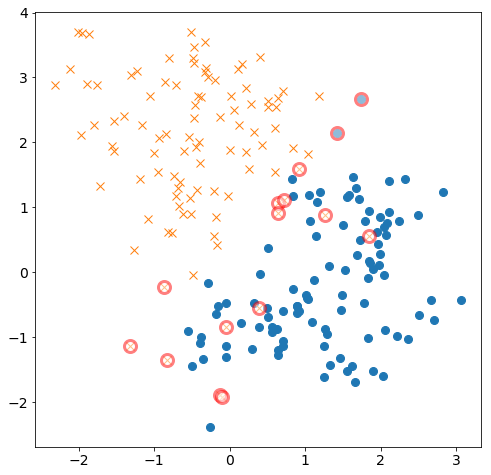

In [8]:
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

errors = (y != est_labels)
plt.plot(X[errors, 0], X[errors, 1], "o", color="red", markeredgewidth=3, markerfacecolor="white", markersize=12, alpha=0.5)
#plt.plot(X[errors, 0], X[errors, 1], "o", color="red", mew=3, mfc="white", ms=12, alpha=0.5)

Now in order to compute the generalization error, we sample a dataset from the same model and compute the new distance matrix.

In [9]:
# Sample test data from the model
testsamples_per_class = 500

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

# Compute distance matrix between X and X_test
distances_test = cdist(X, X_test)
print(distances_test)
print(np.shape(distances_test))

[[ 1.77166668  2.86238329  3.18173659 ...,  3.01802054  3.38792608
   4.86308046]
 [ 1.49790942  2.61345227  2.90094789 ...,  2.6325026   3.09386109
   4.53783601]
 [ 0.07079313  1.1800763   1.47789305 ...,  2.38464066  1.68723592
   4.70423926]
 ..., 
 [ 2.81622689  3.53274126  3.48792457 ...,  0.90319677  3.50369094
   1.96894191]
 [ 4.5224489   4.73691327  4.47489542 ...,  2.23479987  4.35133327
   1.43417556]
 [ 1.9583989   1.97888563  1.73609784 ...,  1.16984401  1.6496543
   3.35379115]]
(200, 1000)


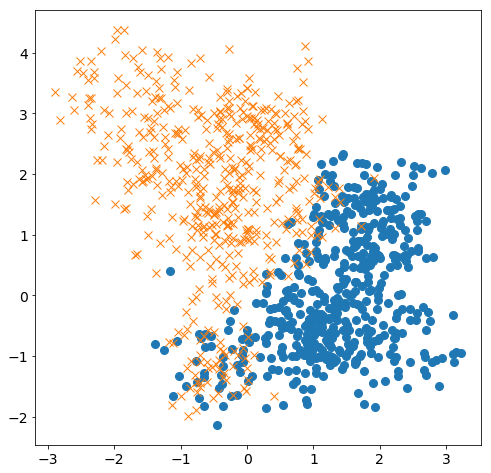

In [10]:
plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], "o", ms=8)
plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], "x", ms=8)

In [11]:
def knn_test(y, distances, k):
    n_train, n_test = np.shape(distances)
    votes = np.zeros(n_test)
    for i in range(n_test):
        for j in np.argpartition(distances[:, i], k)[:k]:
            votes[i] += 1 if y[j] == 1 else -1
    estimate = np.int_(votes > 0)
    return estimate

est_testlabels = knn_test(y, distances_test, 5)
print(est_testlabels)

# Let us compute the test error, now
print(np.mean(y_test != est_testlabels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

k = 1; train error = 0, test error = 0.098
k = 2; train error = 0.04, test error = 0.098
k = 3; train error = 0.035, test error = 0.094
k = 4; train error = 0.04, test error = 0.099
k = 5; train error = 0.055, test error = 0.094
k = 6; train error = 0.07, test error = 0.097
k = 7; train error = 0.07, test error = 0.093
k = 8; train error = 0.08, test error = 0.101
k = 9; train error = 0.07, test error = 0.098
k = 10; train error = 0.075, test error = 0.101
k = 11; train error = 0.075, test error = 0.102
k = 12; train error = 0.075, test error = 0.1
k = 13; train error = 0.075, test error = 0.098
k = 14; train error = 0.075, test error = 0.099
k = 15; train error = 0.06, test error = 0.093
k = 16; train error = 0.075, test error = 0.093
k = 17; train error = 0.06, test error = 0.09
k = 18; train error = 0.065, test error = 0.094
k = 19; train error = 0.055, test error = 0.091


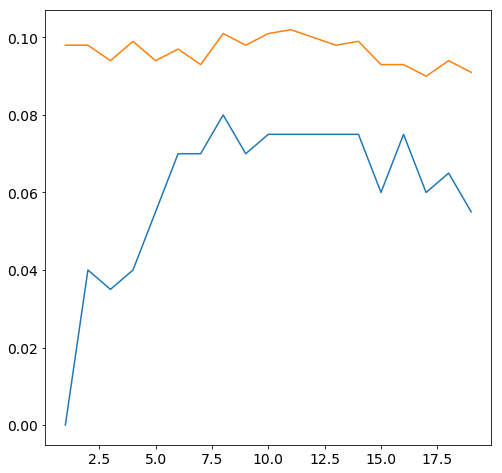

In [13]:
def compute_train_error(X, y, k=1):
    dist = cdist(X, X)
    y_hat = knn(y, dist, k)
    return np.mean(y != y_hat)
    
def compute_test_error(X_train, y_train, X_test, y_test, k=1):
    dist = cdist(X_train, X_test)
    y_hat = knn_test(y_train, dist, k)
    return np.mean(y_test != y_hat)

ks = np.arange(1, 20)
train_error = []
test_error = []
for k in ks:
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

plt.plot(ks, train_error)
plt.plot(ks, test_error)

k = 1; train error = 0, test error = 0.098
k = 2; train error = 0.04, test error = 0.098
k = 3; train error = 0.035, test error = 0.094
k = 4; train error = 0.04, test error = 0.099
k = 5; train error = 0.055, test error = 0.094
k = 6; train error = 0.07, test error = 0.097
k = 7; train error = 0.07, test error = 0.093
k = 8; train error = 0.08, test error = 0.101
k = 9; train error = 0.07, test error = 0.098
k = 10; train error = 0.075, test error = 0.101
k = 40; train error = 0.075, test error = 0.096
k = 70; train error = 0.08, test error = 0.11
k = 100; train error = 0.085, test error = 0.119
k = 130; train error = 0.09, test error = 0.125


(0.025, 0.125)

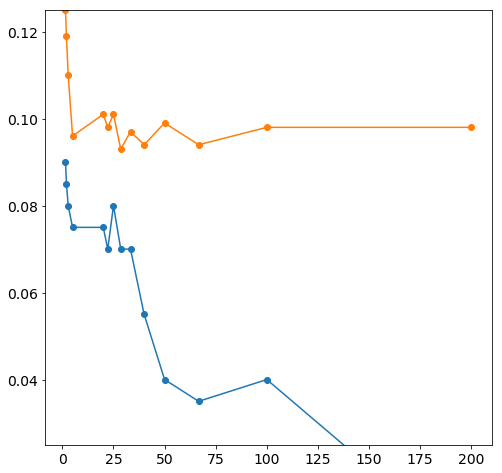

In [17]:
ks = np.r_[np.arange(1, 10), np.arange(10, 150, 30)]
train_error = []
test_error = []
for k in ks:
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

plt.plot(200 / np.array(ks), train_error, "-o")
plt.plot(200 / np.array(ks), test_error, "-o")
plt.ylim((0.025, 0.125))

## A Python library for Machine Learning: scikit-learn

## Classification on real datasets: MNIST